In [7]:
import sqlite3
from sqlite3.dbapi2 import connect
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

### 1. Создайте и заполните таблицу запросами, создайте техническое поле ID c параметрами INTEGER PRIMARY KEY AUTOINCREMENT.

In [8]:
con = sqlite3.connect('works.sqlite')
cur = con.cursor()

cur.execute("drop table if exists works")
cur.execute('''
            CREATE TABLE works(
            ID INTEGER PRIMARY KEY AUTOINCREMENT,
            salary INTEGER,
            educationType TEXT,
            jobTitle TEXT,
            qualification TEXT,
            gender TEXT,
            dateModify TEXT,
            skills TEXT,
            otherInfo TEXT)
            ''')

con.commit()

data = pd.read_csv('works.csv')
data.to_sql('works', con, if_exists='append', index=None)
con.commit()

### 2. Добавьте индекс на поле salary. Изменится ли после этого размер файла? На сколько?

In [9]:
cur.execute('select * from works limit 5')
cur.fetchall()

print(os.path.getsize('works.sqlite') / 1024/ 1024, "Мб")
cur.execute("create index salary_index on works(salary)")

6.52734375 Мб


### 3. Выведите количество записей.

In [10]:
cur.execute('select count(ID) from works')
cur.fetchall()

[(32683,)]

### 4. Выведите количество мужчин и женщин.

In [11]:
cur.execute('select gender, count(*) from works group by gender')
cur.fetchall()

[(None, 1387), ('Женский', 17910), ('Мужской', 13386)]

### 5. У скольки записей заполены skills?

In [12]:
cur.execute('select count(*) from works where skills not Null')
cur.fetchall()

[(8972,)]

### 6. Получить заполненные скиллы.

In [13]:
cur.execute('select distinct skills from works where skills not Null')
cur.fetchall()

[('<p>Аналитическое&nbsp;мышление,&nbsp;<span class="s6"><span class="bumpedFont15">ответственность, </span></span><span class="s6"><span class="bumpedFont15">стабильность психологического состояния и настроения.&nbsp;</span></span></p>',),
 ('Ответственная,пунктуальная,дисциплинированная я,стрессоустойчивая,легкообучаема ,технически оснащена',),
 ('<p>Коммуникабельность&nbsp;</p>',),
 ('<p>Ответственность в работе</p>',),
 ('<p>Усидчивость, умение удерживать в памяти нужную информацию,скрупулезность, пунктуальность, умение планировать и организовать рабочий процесс,дальновидность, умение собирать и анализировать данные, аккуратность, нацеленность на результат.</p>',),
 ('<p>Владение&nbsp;ПК:&nbsp;MsOffice,&nbsp;1С:ЗУП&nbsp;8.3,&nbsp;&laquo;Консультант+&raquo;</p><p>Знание&nbsp;ТК&nbsp;РФ,&nbsp;делового&nbsp;этикета.</p><p>Опыт&nbsp;работы&nbsp;в&nbsp;условиях&nbsp;многозадачности.</p><p>Опыт&nbsp;консультирования&nbsp;клиентов.&nbsp;</p><p>Консультирование&nbsp;сотрудников&nbsp;по&nbs

### 7. Вывести зарплату только у тех, у кого в скилах есть Python.

In [14]:
cur.execute('select salary from works where skills like "%python%"')
cur.fetchall()

[(35000,),
 (20000,),
 (35000,),
 (15000,),
 (25000,),
 (90000,),
 (30000,),
 (50000,),
 (23000,),
 (23000,)]

### 8. Построить перцентили и разброс по з/п у мужчин и женщин.

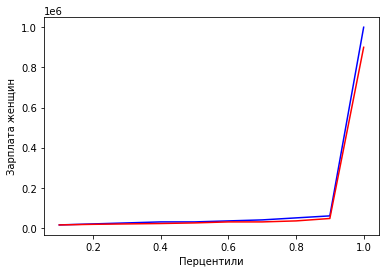

In [15]:
percent = np.linspace(0.1, 1, 10)

cur.execute('select salary from works where gender = "Мужской"')
male = np.quantile([row[0] for row in cur.fetchall()], percent)

cur.execute('select salary from works where gender = "Женский"')
female = np.quantile([row[0] for row in cur.fetchall()], percent)

plt.plot(percent, male, color="b")
plt.plot(percent, female, color="r")
plt.xlabel("Перцентили")
plt.ylabel("Зарплата женщин")

plt.show()

### 9.  Построить графики распределения по з/п мужчин и женщин (а также в зависимости от высшего образования).

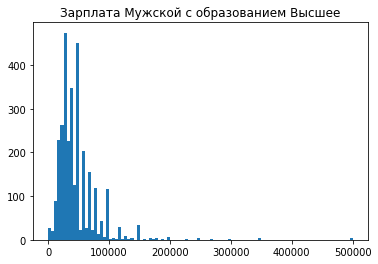

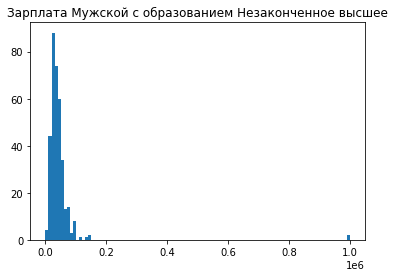

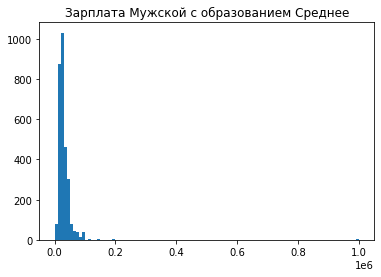

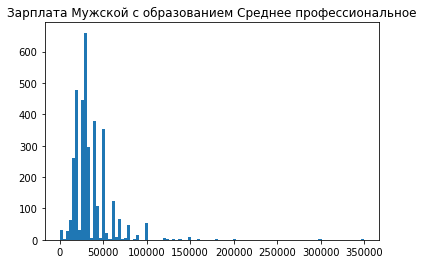

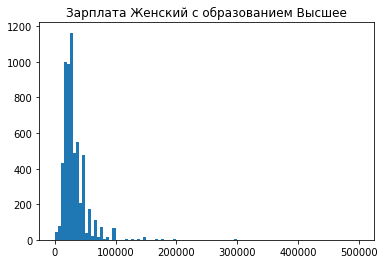

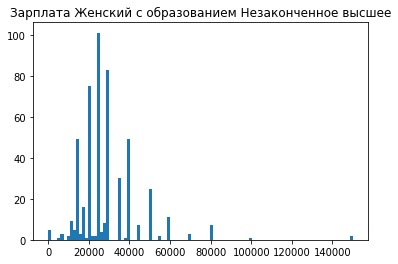

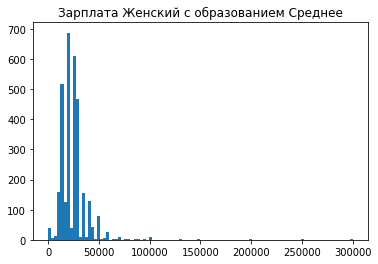

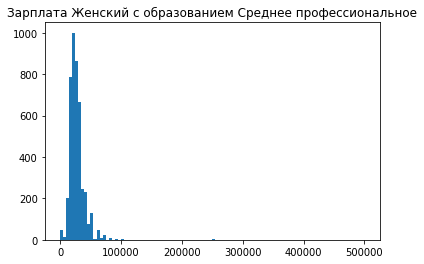

In [16]:
params = [("Мужской", "Высшее"), ("Мужской", "Незаконченное высшее"), ("Мужской", "Среднее"),
("Мужской", "Среднее профессиональное"), ("Женский", "Высшее"), ("Женский", "Незаконченное высшее"),
("Женский", "Среднее"), ("Женский", "Среднее профессиональное")]

for p in params:
    sql_query = f"SELECT salary FROM works WHERE gender = '{p[0]}' and educationType = '{p[1]}'"
    salary = [row[0] for row in cur.execute(sql_query).fetchall()]
    plt.hist(salary, bins=100)
    plt.title(f"Зарплата {p[0]} с образованием {p[1]}")
    plt.show()

In [17]:
# 1,2

Скилы и otherInfo
Эти поля крайне засорены HTML-разметкой. Например, самое длинное описание скилов занимает 11Кб.


In [18]:
import re

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

cols = ['skills', 'otherInfo']

for col in cols:
    cur.execute(f"select ID, {col} from works where {col} not null")
    
    for row in cur.fetchall():
        clean = (re.sub(CLEANR, '', row[1]), row[0])
        cur.execute(f"update works SET {col} = ? where ID = ?", clean)
        
cur.execute("select skills, otherInfo from works where skills not null and otherInfo not null limit 15")
cur.fetchall()

[('Ответственность в работе',
  'Провожу время в семье, люблю велоспорт, природу, путешествия.'),
 ('Хорошо обучаемая', 'Прошу поставить на биржу труда как безработную'),
 ('Лидерство, умение быть наставником, умение анализировать, обучаемость.',
  'Новатор, рационализатор, люблю творческие проекты, рутину предпочитаю автоматизировать или делегировать.В работе важны возможность развития и достойная оплата.'),
 ('Дисциплинированность, ответственность, стремление к карьерному росту. Открыт к обучаемости',
  'Разбираюсь в продаже недвижимости.'),
 ('Вредных привычек не имею.Умение работать в команде.Умею делать четкие замеры.',
  'По запросу предъявлю рекомендации.'),
 ('Microsoft Office, Компас 3D',
  'Дополнительное развитие:Март, 2014  благодарное письмо за участие в Областном форуме научной молодежи Шаг в будущее, тема доклада Анализ уровня воспроизводства экономического плодородия почв в Костромской области.Октябрь, 2016  статья на тему Расчет параметров запредельных волноводов камер